## Life expectancy Principal Component Analysis
--------------------------------------

### About the dataset:
The below data was collected from WHO and United Nations to keep track of the health status as well as many other related factors in different countries. The data-set related to life expectancy, health factors for 193 countries has been collected from the same WHO data repository website and its corresponding economic data was collected from United Nation website. Among all categories of health-related factors only those critical factors were chosen which are more representative. It has been observed that in the past 15 years , there has been a huge development in health sector resulting in improvement of human mortality rates especially in the developing nations in comparison to the past 30 years. Therefore, in this project we have considered data from year 2000-2015 for 193 countries for further analysis. The individual data files have been merged together into a single data-set. The final merged file(final dataset) consists of 22 Columns and 2938 rows.

The content of the dataset includes:

* **Country**: The country that data was collected
* **Year**: The year the data was collected
* **Status**: Developed or Developing status
* **Life expectancy**: Life Expectancy in age
* **Adult Mortality**: Adult Mortality Rates of both sexes (probability of dying between 15 and 60 years per 1000 population)
* **infant deaths**: Number of Infant Deaths per 1000 population
* **Alcohol**: Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol)
* **percentage expenditure**: Expenditure on health as a percentage of Gross Domestic Product per capita(%)
* **Hepatitis B**: Hepatitis B (HepB) immunization coverage among 1-year-olds (%)
* **Measles**: Measles - number of reported cases per 1000 population
* **BMI**: Average Body Mass Index of entire population
* **under-five deaths**: Number of under-five deaths per 1000 population
* **PolioPolio**: (Pol3) immunization coverage among 1-year-olds (%)
* **Total expenditure**: General government expenditure on health as a percentage of total government expenditure (%)
* **Diphtheria**: Diphtheria tetanus toxoid and pertussis (DTP3) immunization coverage among 1-year-olds (%)
* **HIV/AIDS**: Deaths per 1 000 live births HIV/AIDS (0-4 years)
* **GDP**: Gross Domestic Product per capita (in USD)
* **Population**: Population of the country
* **thinness 1-19 years**: Prevalence of thinness among children and adolescents for Age 10 to 19 (% )
* **thinness 5-9 years**: Prevalence of thinness among children for Age 5 to 9(%)
* **Income composition of resources**: Human Development Index in terms of income composition of resources (index ranging from 0 to 1)
* **Schooling**: Number of years of Schooling(years)



In [1]:
# Import libraries:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
from scipy.stats.mstats import winsorize
from scipy.stats import boxcox
import warnings

warnings.filterwarnings('ignore')

### Load the dataset:

In [2]:
# Connect to the dataset from the database:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('SELECT * FROM lifeexpectancy', con=engine)

# Dispose the connection since we're only doing a single query
engine.dispose()

# Print out the first 5 rows of the data:
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


### Data cleaning and exploration (EDA):
#### Data cleaning:

In [3]:
# Clean out column names:
df.rename(columns={'infant deaths':'Infant deaths', 'percentage expenditure':'Percentage expenditure', 
                  'under-five deaths ':'Under-five deaths',' thinness  1-19 years':'Thinness 1-19 years', 
                   ' thinness 5-9 years':'Thinness 5-9 years'}, inplace=True)

# Strip whitespaces in column name:
df = df.rename(columns=lambda x: x.strip())

# Inspect column datatypes and missing values:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
Infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
Percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
BMI                                2904 non-null float64
Under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
HIV/AIDS                           2938 non-null

As we can see, there is a mix of object, int64 and float64 datatypes. 'Country' and 'status' field makes sense as object type. 'Year' makes sense to be integer. Let's convert the rest of the variables to float64 to keep consistency in column datatypes.

In [4]:
# Convert column datatypes to float64 for consistency:
df['Infant deaths'] = df['Infant deaths'].astype('float64')
df['Measles'] = df['Measles'].astype('float64')
df['Under-five deaths'] = df['Under-five deaths'].astype('float64')

df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,Infant deaths,Alcohol,Percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,Thinness 1-19 years,Thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62.0,0.01,71.279624,65.0,1154.0,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64.0,0.01,73.523582,62.0,492.0,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66.0,0.01,73.219243,64.0,430.0,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69.0,0.01,78.184215,67.0,2787.0,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71.0,0.01,7.097109,68.0,3013.0,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


#### Deal with missing values:
Since the dataset was collected over the course of 15 years and there was not a lot of missing values within each variable, we'll use pandas interpolate method to fill in missing values.

In [5]:
# Fill na values using interpolation method. There shouldn't be any missing values after this step is completed:
df = df.interpolate(method='linear')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2938 non-null float64
Adult Mortality                    2938 non-null float64
Infant deaths                      2938 non-null float64
Alcohol                            2938 non-null float64
Percentage expenditure             2938 non-null float64
Hepatitis B                        2938 non-null float64
Measles                            2938 non-null float64
BMI                                2938 non-null float64
Under-five deaths                  2938 non-null float64
Polio                              2938 non-null float64
Total expenditure                  2938 non-null float64
Diphtheria                         2938 non-null float64
HIV/AIDS                           2938 no

#### Explore correlations between variables:

In [6]:
# Explore correlation of different variables:
correlation = df.corr()
correlation['Life expectancy']

Year                               0.168309
Life expectancy                    1.000000
Adult Mortality                   -0.695730
Infant deaths                     -0.196197
Alcohol                            0.400068
Percentage expenditure             0.382069
Hepatitis B                        0.247419
Measles                           -0.157298
BMI                                0.556433
Under-five deaths                 -0.222151
Polio                              0.459865
Total expenditure                  0.210843
Diphtheria                         0.474084
HIV/AIDS                          -0.555929
GDP                                0.435854
Population                        -0.007126
Thinness 1-19 years               -0.476809
Thinness 5-9 years                -0.472485
Income composition of resources    0.690071
Schooling                          0.703409
Name: Life expectancy, dtype: float64

Since we are interested in factors that would increase life expectancy, we want to eliminate variables that have negative correlations or very small correlations with life expectancy. These include 'Adult Mortality', 'Infant deaths', 'Measles', 'Under-five deaths', 'HIV/AIDS', 'Country', 'Population', 'Thinness 1-19 years', 'Thinness 5-9 years', 'Year', 'Status', 'Hepatitis B', 'Total expenditure' as indicated above.

In [7]:
# Drop variables wtih negative or very small correlations with life expectancy:
df.drop(['Adult Mortality', 'Infant deaths', 'Measles', 'Under-five deaths', 'HIV/AIDS',
         'Country', 'Population', 'Thinness 1-19 years', 'Thinness 5-9 years', 'Year', 
         'Status', 'Hepatitis B', 'Total expenditure'], axis=1, inplace=True)
df.describe()

,Life expectancy,Alcohol,Percentage expenditure,BMI,Polio,Diphtheria,GDP,Income composition of resources,Schooling
count,2938.000000,2938.000000,2938.000000,2938.00000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000
mean,69.214874,4.548919,738.251295,38.29869,82.474643,82.246086,7432.027910,0.634458,12.076804
std,9.510819,3.994854,1987.914858,19.99140,23.420689,23.705664,13410.150286,0.209574,3.342316
min,36.300000,0.010000,0.000000,1.00000,3.000000,2.000000,1.681350,0.000000,0.000000
25%,63.100000,0.902500,4.685343,19.32500,78.000000,78.000000,553.618620,0.500000,10.200000
50%,72.000000,3.697500,64.912906,43.25000,93.000000,93.000000,2192.681084,0.684000,12.400000
75%,75.600000,7.550000,441.534144,56.10000,97.000000,97.000000,7183.381694,0.791107,14.300000
max,89.000000,17.870000,19479.911610,87.30000,99.000000,99.000000,119172.741800,0.948000,20.700000


#### Eliminate outliners:

Text(0.5, 1.0, 'Schooling')

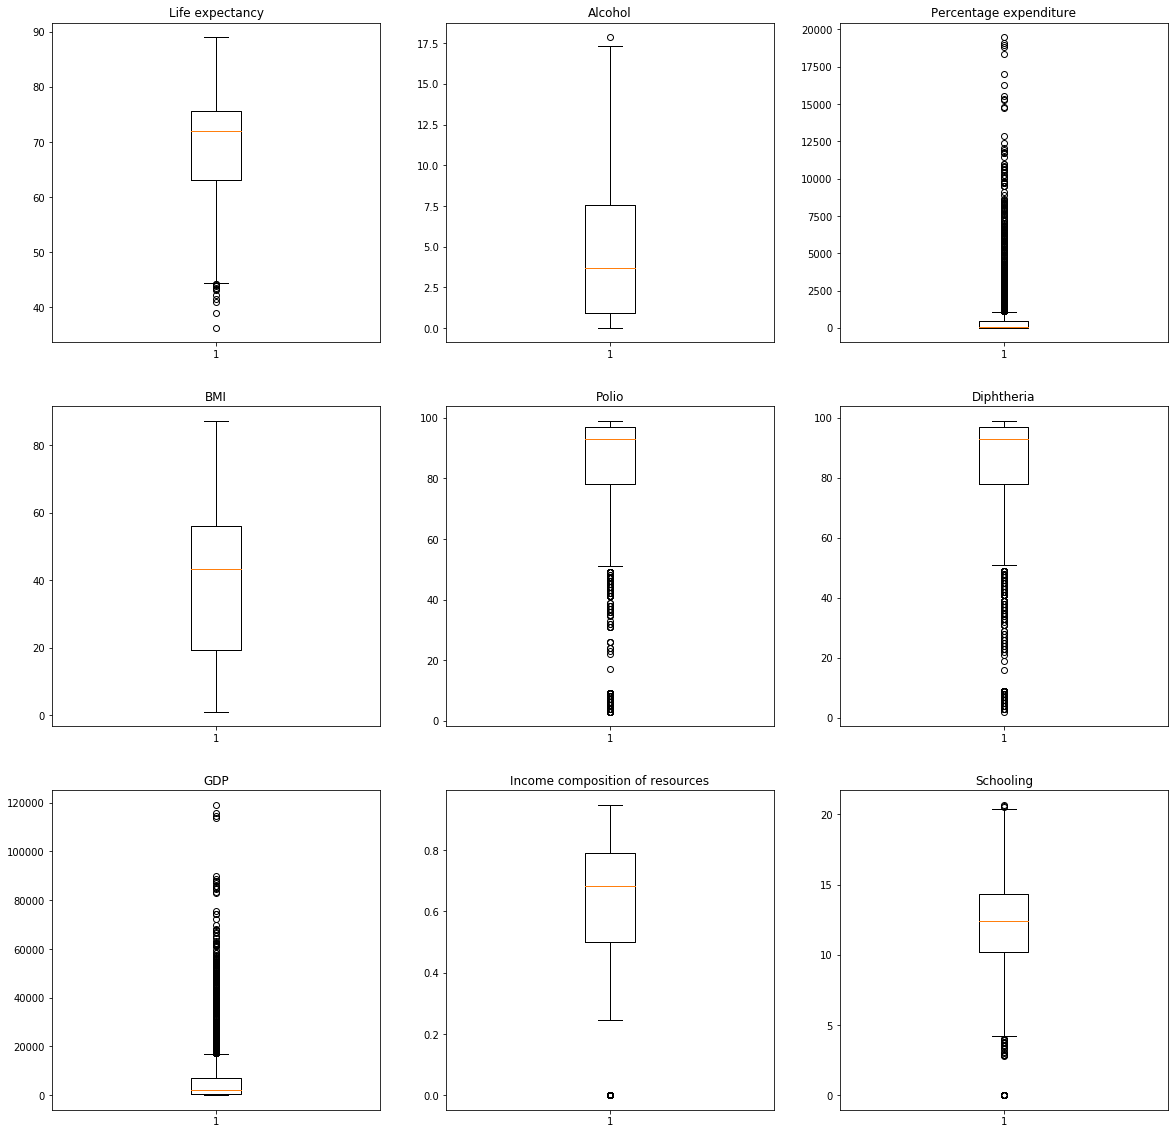

In [8]:
# Visualize dataset to inspect outliners:
plt.figure(figsize=(20,20))

plt.subplot(3,3,1)
plt.boxplot(df['Life expectancy'])
plt.title('Life expectancy')

plt.subplot(3,3,2)
plt.boxplot(df['Alcohol'])
plt.title('Alcohol')

plt.subplot(3,3,3)
plt.boxplot(df['Percentage expenditure'])
plt.title('Percentage expenditure')

plt.subplot(3,3,4)
plt.boxplot(df['BMI'])
plt.title('BMI')

plt.subplot(3,3,5)
plt.boxplot(df['Polio'])
plt.title('Polio')

plt.subplot(3,3,6)
plt.boxplot(df['Diphtheria'])
plt.title('Diphtheria')

plt.subplot(3,3,7)
plt.boxplot(df['GDP'])
plt.title('GDP')

plt.subplot(3,3,8)
plt.boxplot(df['Income composition of resources'])
plt.title('Income composition of resources')

plt.subplot(3,3,9)
plt.boxplot(df['Schooling'])
plt.title('Schooling')

In [9]:
# Use winsorization technique to eliminate outliners:
df['Life expectancy'] = winsorize(df['Life expectancy'],(0.1,0))
df['Income composition of resources'] = winsorize(df['Income composition of resources'],(0.1,0))
df['Schooling'] = winsorize(df['Schooling'],(0.05,0.05))
df['Alcohol'] = winsorize(df['Alcohol'],(0,0.1))
df['Schooling'] = winsorize(df['Schooling'],(0,0.1))
df['GDP'] = winsorize(df['GDP'],(0.1,0))
df['Polio'] = winsorize(df['Polio'],(0.1,0))
df['Diphtheria'] = winsorize(df['Diphtheria'],(0.1,0))

### Explore the data using univariate and multivariate exploration techniques. 

We want to look at the relationship of independent variables and how they drive life expectancy(dependent variable). Let's visualize the relationship of each variable against life expectancy to identify patterns.

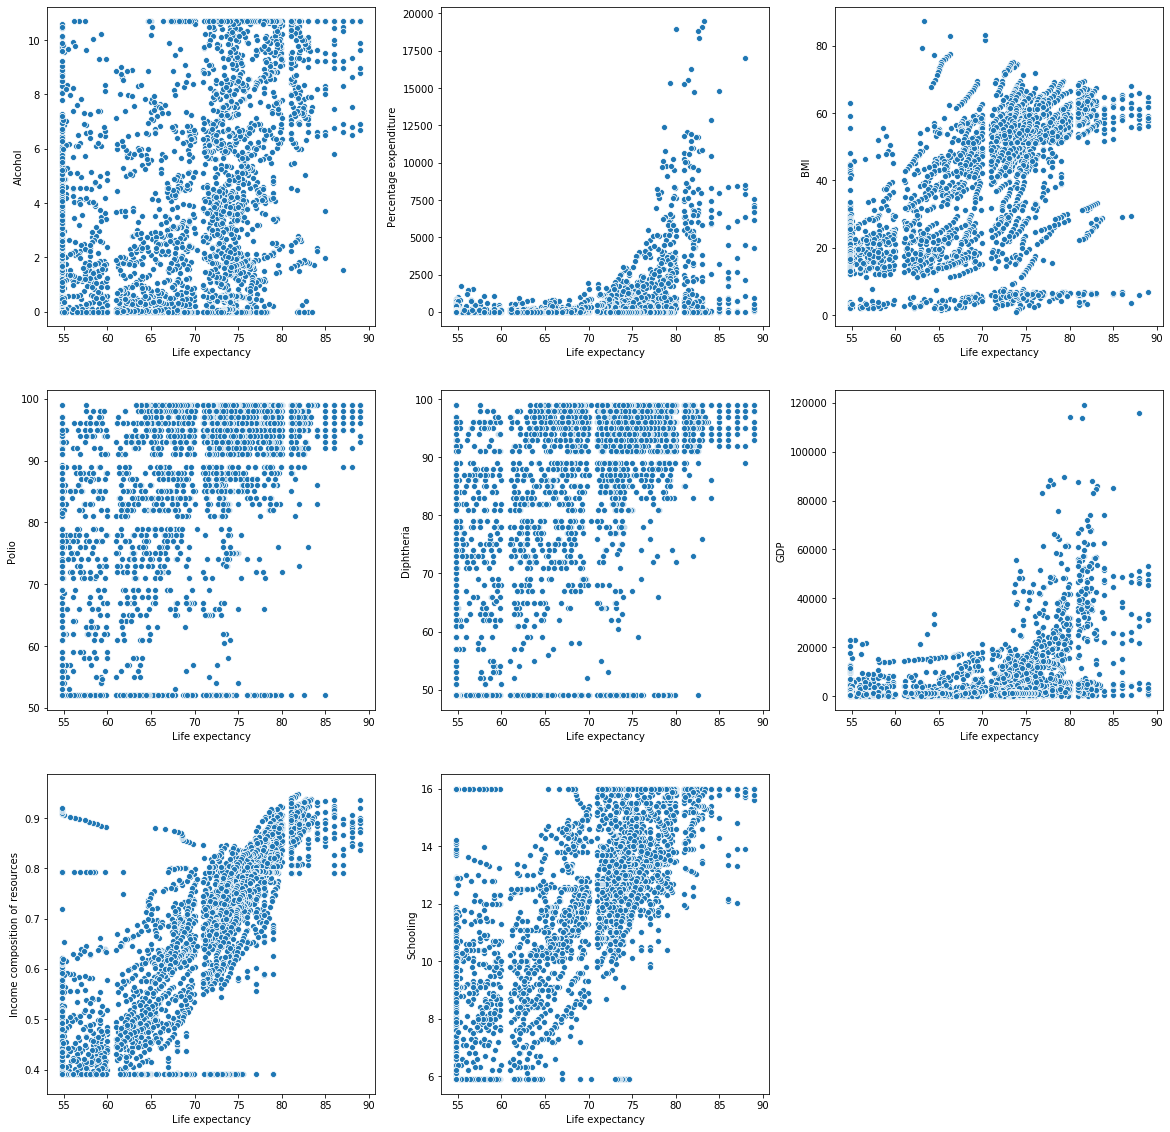

In [10]:
# Analyze relationship of variables to life expectancy
plt.figure(figsize=(20,20))

plt.subplot(3,3,1)
sns.scatterplot('Life expectancy', 'Alcohol', data=df)

plt.subplot(3,3,2)
sns.scatterplot('Life expectancy', 'Percentage expenditure', data=df)

plt.subplot(3,3,3)
sns.scatterplot('Life expectancy', 'BMI', data=df)

plt.subplot(3,3,4)
sns.scatterplot('Life expectancy', 'Polio', data=df)

plt.subplot(3,3,5)
sns.scatterplot('Life expectancy', 'Diphtheria', data=df)

plt.subplot(3,3,6)
sns.scatterplot('Life expectancy', 'GDP', data=df)

plt.subplot(3,3,7)
sns.scatterplot('Life expectancy', 'Income composition of resources', data=df)

plt.subplot(3,3,8)
sns.scatterplot('Life expectancy', 'Schooling', data=df)

As we can see, it's hard to tell how variables interact by looking at the plots above. We can see that there are some positive correlations between (ex: income composition of resources and life expectancy). Let's draw a heat map to quantify correlation.

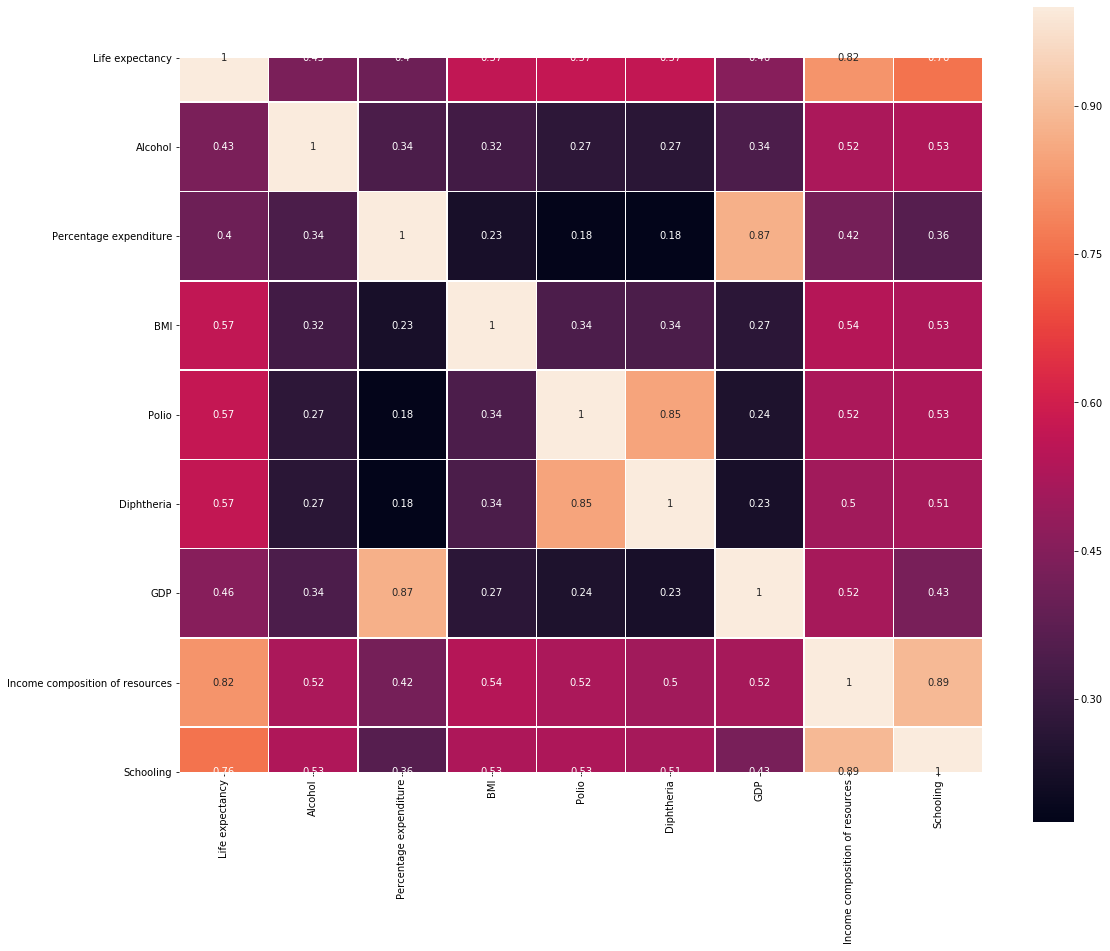

In [11]:
# Create heatmap of variable correlation:
plt.figure(figsize=(18,15))

sns.heatmap(df.corr(), square=True, annot=True, linewidths=.5)
plt.show()

From the heatmap, we can notice the high correlation between GDP and Percentage expenditure and between Diphtheria and Polio. We don't want to include pairs of highly correlated variables in our future model as they will magnify their effect and create bias.

### Feature Enginneer and PCA

In [12]:
# Normalize the data so that all variables have a mean of 0 and standard deviation of 1:
X = StandardScaler().fit_transform(df)

# The NumPy covariance function assumes that variables are represented by rows, not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)

print('Covariance Matrix:\n', Cx)

Covariance Matrix:
 [[1.00034048 0.43010724 0.40410301 0.56699626 0.57280896 0.57086228
  0.45726636 0.81807424 0.75550549]
 [0.43010724 1.00034048 0.33697367 0.31888479 0.271932   0.26767315
  0.34202988 0.52429914 0.53132387]
 [0.40410301 0.33697367 1.00034048 0.22816167 0.17839423 0.17517033
  0.87183105 0.42322856 0.36165952]
 [0.56699626 0.31888479 0.22816167 1.00034048 0.34186292 0.33727076
  0.27140801 0.5449819  0.5285934 ]
 [0.57280896 0.271932   0.17839423 0.34186292 1.00034048 0.85134997
  0.24049734 0.52404786 0.52754594]
 [0.57086228 0.26767315 0.17517033 0.33727076 0.85134997 1.00034048
  0.22681189 0.50413198 0.51476978]
 [0.45726636 0.34202988 0.87183105 0.27140801 0.24049734 0.22681189
  1.00034048 0.51677025 0.42829786]
 [0.81807424 0.52429914 0.42322856 0.5449819  0.52404786 0.50413198
  0.51677025 1.00034048 0.89293966]
 [0.75550549 0.53132387 0.36165952 0.5285934  0.52754594 0.51476978
  0.42829786 0.89293966 1.00034048]]


In [13]:
# Calculating eigenvalues and eigenvectors of covariance:
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print('The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
     eig_val_cov / sum(eig_val_cov))

Eigenvector 1: 
[-0.39872787 -0.275306   -0.26338823 -0.28902901 -0.3177083  -0.3131187
 -0.29241806 -0.41174656 -0.39785188]
Eigenvalue 1: 4.813945817131865
----------------------------------------
Eigenvector 2: 
[-0.08013642  0.11987216  0.58432402 -0.08937983 -0.40468076 -0.41079415
  0.5409781  -0.00798704 -0.06742451]
Eigenvalue 2: 1.4920918359859638
----------------------------------------
Eigenvector 3: 
[ 0.0924783   0.37689555 -0.3097717   0.41646873 -0.4361915  -0.44393149
 -0.29600462  0.21066503  0.24628462]
Eigenvalue 3: 0.922916423359196
----------------------------------------
Eigenvector 4: 
[ 0.16573352 -0.76312242  0.05756238  0.59995943 -0.08732877 -0.08893112
  0.09127648  0.01364159 -0.05347223]
Eigenvalue 4: 0.6800685973291788
----------------------------------------
Eigenvector 5: 
[ 0.26274625 -0.41044306 -0.12163525 -0.6002446  -0.15487544 -0.17937706
 -0.03356362  0.40818437  0.40436204]
Eigenvalue 5: 0.49391102394330766
--------------------------------------

Looking from the analysis above, it looks like the first 2 components carry the largest amount of variance. Let's confirm this by ploting a scree plot.

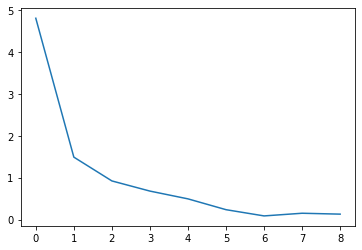

[4.81394582 1.49209184 0.92291642 0.6800686  0.49391102 0.23523676
 0.08615719 0.15002167 0.12871504]


In [14]:
# print scree plot
plt.plot(eig_val_cov)
plt.show()

print(eig_val_cov)

The scree plot again reconfirm that the first 2 components carry the most predicting values. If we choose the cutoff point is <1, then the first 2 components would be the pick

In [15]:
# Apply PCA from sklearn library to inspect the % of variance explained by the 2 first components:

sklearn_pca = PCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X)

print('The percentage of total variance in the dataset explained by each component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.53470081 0.16573155]


Text(0.5, 1, 'First component')

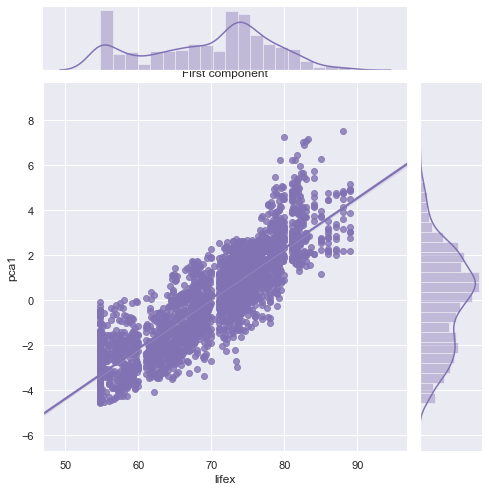

In [20]:
# Plot the first component:
plot = pd.DataFrame({'lifex':df['Life expectancy'],'pca1':Y_sklearn[:, 0],'pca2':Y_sklearn[:, 1]})

sns.set(style="darkgrid")
sns.jointplot('lifex', "pca1", data=plot, kind="reg", color="m", height=7)
plt.title('First component')

Text(0.5, 1, 'Second component')

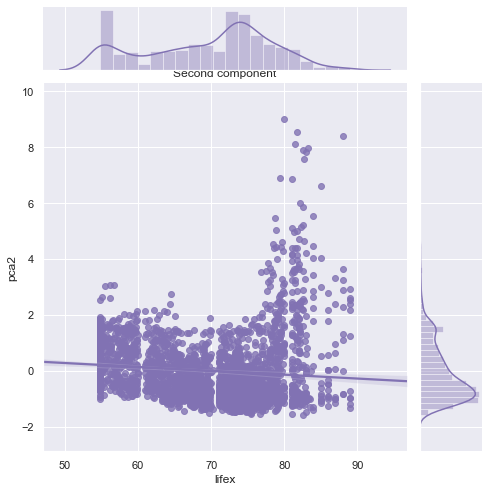

In [21]:
# Plot the second component:
sns.jointplot('lifex', 'pca2', data=plot, kind="reg", color="m", height=7)
plt.title('Second component')